In [14]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from training.util import sgd, plot_losses, adam, lr_scheduler, wilson_scheduler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda")

In [10]:
import experiments.base.cifar as cifar

batch_size = 128
trainloader = cifar.cifar10_trainloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size, subsample=5000)
testloader = cifar.cifar10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size)
stl_testloader = cifar.stl10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=128)

Files already downloaded and verified


In [7]:
import experiments.base.cifar as cifar
corrupted_testloader = cifar.cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=4, batch_size=128)

: 

: 

In [22]:
from training.pp import MAP

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

model = MAP(layers)

model.train_model(160, torch.nn.NLLLoss(), sgd(1e-1, weight_decay=1e-4, momentum=0.9, nesterov=True), trainloader, batch_size, device, scheduler_factory=wilson_scheduler(160, 0.1, None))
#model.load_state_dict(torch.load("/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/2/results/MAP/log/rep_00model.tar"))
model.to(device)

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 0: loss 2.0147554874420166
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1: loss 1.880865454673767
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2: loss 1.7365572452545166
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3: loss 1.7241096496582031
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4: loss 1.586887001991272
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5: loss 1.5148136615753174
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6: loss 1.4849541187286377
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7: loss 1.432898759841919
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8: loss 1.2941534519195557
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9: loss 1.237328290939331
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10: loss 1.227186918258667
Adjusting learning rate of group 0 to 1.0

MAP(
  (model): Sequential(
    (0): PreResNet(
      (model): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (4): ReLU()
            (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (skip_path): Identity()
        )
        (2): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3

In [12]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, stl_testloader, device)

 Accuracy: 0.43424999713897705
 Avg Log Likelihood: -5.012221813201904
 Avg Likelihood: 0.4180564284324646
 ECE: 0.4057955401577055


(tensor(0.4342),
 tensor(-5.0122),
 tensor(0.4181),
 <training.calibration.ClassificationCalibrationResults at 0x7f6c63d8fb20>)

In [ ]:
from training.bbb import BBBModel, GaussianPrior

prior = GaussianPrior(torch.tensor(0), torch.tensor(1))
layers = [
    ("variational-preresnet-20", (32, 3, 10, prior)),
    ("logsoftmax", ())
]

model = BBBModel(layers)

model.train_model(120, torch.nn.NLLLoss(), sgd(1e-1), trainloader, batch_size, device, scheduler_factory=lr_scheduler([80, 120], 0.1), mc_samples=2, kl_rescaling=0.5)

In [ ]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, corrupted_testloader, device)

tensor(0.5264)
 Accuracy: 0.37957367300987244
 Avg Log Likelihood: -2.0528364181518555
 Avg Likelihood: 0.30053094029426575
 ECE: 0.146800649462405


(tensor(0.3796),
 tensor(-2.0528),
 tensor(0.3005),
 <training.calibration.ClassificationCalibrationResults at 0x7fcc00161f70>)

In [19]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.720300018787384
 Avg Log Likelihood: -1.1909916400909424
 Avg Likelihood: 0.6958616971969604
 ECE: 0.15854743110537528


(tensor(0.7203),
 tensor(-1.1910),
 tensor(0.6959),
 <training.calibration.ClassificationCalibrationResults at 0x7f6c75a63c40>)

In [9]:
from training.pp import MAP
from training.vogn import iVONModuleFunctorch, VOGNModule

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

model = VOGNModule(layers)
model.train_model(10, torch.nn.NLLLoss(), {"lr": 1e-4, "prior_prec": 150, "betas": (0.9, 0.999), "damping": 1, "augmentation": 1, "sample": False}, trainloader, batch_size, device, mc_samples=2)

Epoch 0: loss 2.3485770225524902
Epoch 1: loss 2.34991717338562
Epoch 2: loss 2.3480513095855713
Epoch 3: loss 2.3499252796173096


KeyboardInterrupt: 

In [11]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, corrupted_testloader, device)

tensor(0.7874)
 Accuracy: 0.5201526284217834
 Avg Log Likelihood: -2.049781560897827
 Avg Likelihood: 0.493396133184433
 ECE: 0.26724077704540994


(tensor(0.5202),
 tensor(-2.0498),
 tensor(0.4934),
 <training.calibration.ClassificationCalibrationResults at 0x7fd9bd87dfa0>)

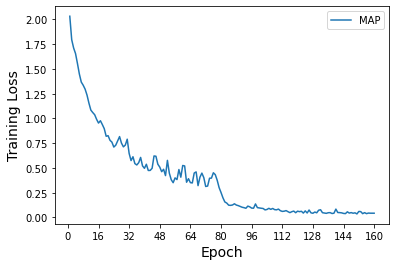

In [20]:
plot_losses("MAP", model.all_losses(), plt.subplot())